## Import packages

In [2]:
import dva_sdhdf_combine_v3
import imp
import os
import subprocess
import h5py
import numpy as np
from astropy.time import Time
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import datetime
import matplotlib.dates as mdates
from matplotlib.dates import HourLocator as HourLocator
from matplotlib.dates import MinuteLocator as MinuteLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy import units as u
from astropy.time import TimeDelta
from astropy.modeling import models, fitting
from astropy.coordinates import SkyCoord,EarthLocation, AltAz, ICRS, Galactic, FK4, FK5
import gc

## NOTE: if files containing desired days and frequencies have already been created, skip to "Read in selected daily map data"

## Select range of days, frequencies, and bandwidth to average over:

In [ ]:
days_list = list(range(1,37))
freq_list = [520.0,800.0]
freq_width= 5.0

## Read in the scan IDs and times

In [ ]:
scan_id = []    # The scan id number
scan_start = []  # Start time of the scan (UTC)
scan_stop = []   # Stop time of the scan (UTC)
day_array = []

# Read in the data and store it in arrays:
for day in days_list:
    #dir_in = '/media/ordoga/DVA_data/survey_phase1_day'+f"{day:02}"+'/'
    dir_in = '/srv/data/dva/survey_azimuth_scans/'
    with open(dir_in+'DVAsurvey_phase3_day0'+f"{day:02}"+'.txt') as fp:
        for line in fp:       
            scan_id.append(int(line.split()[0]))
            scan_start.append(line.split()[1]+'T'+line.split()[2][0:12])
            scan_stop.append(line.split()[3]+'T'+line.split()[4][0:12])
            day_array.append(day)
        
# Print out the scan numbers with their start and stop times:
for i in range(0,len(scan_id)):
    print(day_array[i],f"{scan_id[i]:04}",scan_start[i],scan_stop[i])

## Read in frequency array from one of the scans

In [ ]:
scan0 = f"{scan_id[0]:04}"
#dir_in = '/media/ordoga/DVA_data/survey_phase1_day'+f"{days_list[0]:02}"+'/'
dir_in = '/srv/data/dva/survey_azimuth_scans/'
file = h5py.File(dir_in+'dva_survey_phase3_raw_'+scan0+'.h5','r')
freq = file['data']['beam_0']['band_SB0']['frequency'][:]/1e6
print(freq)

## Set up frequencies ranges over which to average

In [ ]:
freq_idx = []

for freq_pick in freq_list:
    freq_idx.append(np.where(abs(freq-freq_pick)<=freq_width/2.)[0])

for i in range(0,len(freq_idx)):
    print(i)
    print(freq[freq_idx[i]])
    print('')
    

## Set up new data arrays combining all scans and calculate medians for correlation products
### Note: will take a LONG time to run! (took over 3 hours for 969 scans at 2 frequencies)

In [ ]:
%%time

t_set = []
az_set = []
dec_set = []
ra_set = []
el_set = []
noise_set = []
trim_flag = []

# Create empty arrays for the power data:
RR_set = np.empty([0,len(freq_idx)])
LL_set = np.empty([0,len(freq_idx)])
reRL_set = np.empty([0,len(freq_idx)])
imRL_set = np.empty([0,len(freq_idx)])
    
    
# Loop through all the scans in the "scan_num" list:   
for i in range(0,len(scan_id)):
    
    # select the file:
    #dir_in = '/media/ordoga/DVA_data/survey_phase1_day'+f"{day_array[i]:02}"+'/'
    dir_in = '/srv/data/dva/survey_azimuth_scans/'
    file = h5py.File(dir_in+'dva_survey_phase3_raw_'+f"{scan_id[i]:04}"+'.h5','r')
    print(f"{i:04}",f"{day_array[i]:02}",f"{scan_id[i]:04}",file)
    
    # access the correct location in the file structure:
    dataset = file['data']['beam_0']['band_SB0']['scan_0']
    
    # Add the position and time data to the corresponding arrays:
    dec_set = np.concatenate([dec_set,dataset['metadata']['declination']])
    ra_set = np.concatenate([ra_set,dataset['metadata']['right_ascension']])
    el_set = np.concatenate([el_set,dataset['metadata']['elevation']])
    az_set = np.concatenate([az_set,dataset['metadata']['azimuth']])
    t_set = np.concatenate([t_set,dataset['metadata']['utc']])
    noise_set = np.concatenate([noise_set,dataset['metadata']['noise_state']])
    trim_flag = np.concatenate([trim_flag,dataset['metadata']['trim_scan_flag']])
    
    RR = np.empty([len(dataset['metadata']['utc']),len(freq_idx)])
    LL = np.empty([len(dataset['metadata']['utc']),len(freq_idx)])
    reRL = np.empty([len(dataset['metadata']['utc']),len(freq_idx)])
    imRL = np.empty([len(dataset['metadata']['utc']),len(freq_idx)])
    
    for i in range(0,len(freq_idx)):
        #print(i)
        #print(freq[freq_idx[i]])
        RR[:,i] = np.nanmedian(dataset['data'][:,0,freq_idx[i]],axis=1)
        LL[:,i] = np.nanmedian(dataset['data'][:,1,freq_idx[i]],axis=1)
        reRL[:,i] = np.nanmedian(dataset['data'][:,2,freq_idx[i]],axis=1)
        imRL[:,i] = np.nanmedian(dataset['data'][:,3,freq_idx[i]],axis=1)
    # Add the spectrometer power data to the corresponding arrays:
    RR_set = np.concatenate([RR_set,RR],axis=0)
    LL_set = np.concatenate([LL_set,LL],axis=0)
    reRL_set = np.concatenate([reRL_set,reRL],axis=0)
    imRL_set = np.concatenate([imRL_set,imRL],axis=0)
    
    del RR
    del LL
    del reRL    
    del imRL
    gc.collect()
    
t_set_plt = Time(t_set, format='isot',scale='utc').mjd

## Get rid of points where RA=24 artifact occurs

In [ ]:
ra_set_trim = ra_set.copy()
dec_set_trim = dec_set.copy()
az_set_trim = az_set.copy()
el_set_trim = el_set.copy()
t_set_trim = t_set.copy()
t_set_plt_trim = t_set_plt.copy()
noise_set_trim = noise_set.copy()
RR_set_trim = RR_set.copy()
LL_set_trim = LL_set.copy()
reRL_set_trim = reRL_set.copy()
imRL_set_trim = imRL_set.copy()

idxtrim = np.where(trim_flag == 1)[0]
#print(idxtrim)

ra_set_trim[idxtrim] = np.nan
dec_set_trim[idxtrim] = np.nan 
az_set_trim[idxtrim] = np.nan 
el_set_trim[idxtrim] = np.nan 
t_set_trim[idxtrim] = np.nan 
t_set_plt_trim[idxtrim] = np.nan 
noise_set_trim[idxtrim] = np.nan 
RR_set_trim[idxtrim,:] = np.nan 
LL_set_trim[idxtrim,:] = np.nan 
reRL_set_trim[idxtrim,:] = np.nan 
imRL_set_trim[idxtrim,:] = np.nan

## Write out all new arrays and parameters to .npy file

In [ ]:
#filename = '../DVA2/DATA/Daily_maps/survey_phase3_upto_day'+str(days_list[-1])+'.npy'
filename = '/srv/data/dva/survey_phase3_upto_day'+str(days_list[-1])+'.npy'
np.save(filename,([RR_set_trim,LL_set_trim,reRL_set_trim,imRL_set_trim,
                    ra_set_trim,dec_set_trim,az_set_trim,el_set_trim,
                    t_set_trim,noise_set_trim,t_set_plt_trim,
                    day_array,scan_id,scan_start,scan_stop,freq_list,freq_width]))


## Read in selected daily map data

In [ ]:
data = np.load('/srv/data/dva/survey_phase3_upto_day36.npy',allow_pickle=True)

RR_set3 = data[0].astype(float)
LL_set3 = data[1].astype(float)
reRL_set3 = data[2].astype(float)
imRL_set3 = data[3].astype(float)
ra_set3 = data[4].astype(float)
dec_set3 = data[5].astype(float)
az_set3 = data[6].astype(float)
el_set3 = data[7].astype(float)
t_set3 = data[8].copy()
noise_set3 = data[9].astype(float)
t_set_plt3 = data[10].astype(float)
day_array3 = data[11]
scan_id3 = data[12]
scan_start3 = data[13]
scan_stop3 = data[14]
freq_list3 = data[15]
ra_set_deg3 = ra_set3*360./24.

data = np.load('/srv/data/dva/survey_phase1_upto_day47.npy',allow_pickle=True)

RR_set1 = data[0].astype(float)
LL_set1 = data[1].astype(float)
reRL_set1 = data[2].astype(float)
imRL_set1 = data[3].astype(float)
ra_set1 = data[4].astype(float)
dec_set1 = data[5].astype(float)
az_set1 = data[6].astype(float)
el_set1 = data[7].astype(float)
t_set1 = data[8].copy()
noise_set1 = data[9].astype(float)
t_set_plt1 = data[10].astype(float)
day_array1 = data[11]
scan_id1 = data[12]
scan_start1 = data[13]
scan_stop1 = data[14]
freq_list1 = data[15]
ra_set_deg1 = ra_set1*360./24.

## Set points when noise source is on to NaN

In [ ]:
wbad3 = np.where(noise_set3 == 1.0)
RR_set3[wbad3] = np.nan
LL_set3[wbad3] = np.nan
reRL_set3[wbad3] = np.nan
imRL_set3[wbad3] = np.nan

wbad1 = np.where(noise_set1 == 1.0)
RR_set1[wbad1] = np.nan
LL_set1[wbad1] = np.nan
reRL_set1[wbad1] = np.nan
imRL_set1[wbad1] = np.nan

## Calculate Galactic coordinates (takes several minutes)

In [ ]:
%%time
loc = EarthLocation(lat = 49.32*u.deg, lon = -119.62*u.deg, height = 546*u.m)

wgood3 = np.where(np.isfinite(el_set3))

AltAzcoord = SkyCoord(alt=el_set3[wgood3]*u.deg, az=az_set3[wgood3]*u.deg, 
                      obstime=Time(t_set3[wgood3],format='isot',scale='utc',location=loc),
                      frame = 'altaz', location = loc)

ra3 = AltAzcoord.icrs.ra.deg
dec3 = AltAzcoord.icrs.dec.deg

l3 = AltAzcoord.galactic.l.deg
b3 = AltAzcoord.galactic.b.deg

In [ ]:
%%time
loc = EarthLocation(lat = 49.32*u.deg, lon = -119.6*u.deg, height = 546*u.m)

wgood1 = np.where(np.isfinite(el_set1))

AltAzcoord1 = SkyCoord(alt=el_set1[wgood1]*u.deg, az=az_set1[wgood1]*u.deg, 
                      obstime=Time(t_set1[wgood1],format='isot',scale='utc',location=loc),
                      frame = 'altaz', location = loc)

ra1 = AltAzcoord1.icrs.ra.deg
dec1 = AltAzcoord1.icrs.dec.deg

l1 = AltAzcoord1.galactic.l.deg
b1 = AltAzcoord1.galactic.b.deg

In [ ]:
print(t_set1[wgood1].shape)
print(RR_set1[wgood1].shape)

In [ ]:
filename = '/srv/data/dva/survey_phase3_upto_day36_skycoord.npy'
np.save(filename,([RR_set3[wgood3],LL_set3[wgood3],reRL_set3[wgood3],imRL_set3[wgood3],
                   ra_set3[wgood3],dec_set3[wgood3],az_set3[wgood3],el_set3[wgood3],
                   t_set3[wgood3],noise_set3[wgood3],t_set_plt3[wgood3],day_array3,
                   scan_id3,scan_start3,scan_stop3,freq_list3,ra3,dec3,l3,b3]))

filename = '/srv/data/dva/survey_phase1_upto_day47_skycoord.npy'
np.save(filename,([RR_set1[wgood1],LL_set1[wgood1],reRL_set1[wgood1],imRL_set1[wgood1],
                   ra_set1[wgood1],dec_set1[wgood1],az_set1[wgood1],el_set1[wgood1],
                   t_set1[wgood1],noise_set1[wgood1],t_set_plt1[wgood1],day_array1,
                   scan_id1,scan_start1,scan_stop1,freq_list1,ra1,dec1,l1,b1]))

In [ ]:
print(freq_list)

# Map-making code starts here:

In [3]:
[RR_set3,LL_set3,reRL_set3,imRL_set3,ra_set3,dec_set3,az_set3,el_set3,
t_set3,noise_set3,t_set_plt3,day_array3,scan_id3,scan_start3,scan_stop3,
freq_list3,ra3,dec3,l3,b3] = np.load('/srv/data/dva/survey_phase3_upto_day36_skycoord.npy',allow_pickle=True)

[RR_set1,LL_set1,reRL_set1,imRL_set1,ra_set1,dec_set1,az_set1,el_set1,
t_set1,noise_set1,t_set_plt1,day_array1,scan_id1,scan_start1,scan_stop1,
freq_list1,ra1,dec1,l1,b1] = np.load('/srv/data/dva/survey_phase1_upto_day47_skycoord.npy',allow_pickle=True)

## Median subtract reRL and imRL (estimate instrumental pol.) and calculate polarized intensity

In [4]:
reRL_set_instr3 = reRL_set3.copy()
imRL_set_instr3 = imRL_set3.copy()

for i in range(0,len(freq_list3)):
    reRL_med3 = np.nanmedian(reRL_set3[:,i])
    imRL_med3 = np.nanmedian(imRL_set3[:,i])
    reRL_set_instr3[:,i] = reRL_set_instr3[:,i] - reRL_med3
    imRL_set_instr3[:,i] = imRL_set_instr3[:,i] - imRL_med3

wbad3 = np.where(noise_set3 == 1.0)
PI3 = np.sqrt(reRL_set_instr3**2 + imRL_set_instr3**2)
PI3[wbad3] = np.nan


reRL_set_instr1 = reRL_set1.copy()
imRL_set_instr1 = imRL_set1.copy()

for i in range(0,len(freq_list1)):
    reRL_med1 = np.nanmedian(reRL_set1[:,i])
    imRL_med1 = np.nanmedian(imRL_set1[:,i])
    reRL_set_instr1[:,i] = reRL_set_instr1[:,i] - reRL_med1
    imRL_set_instr1[:,i] = imRL_set_instr1[:,i] - imRL_med1
    
wbad1 = np.where(noise_set1 == 1.0)
PI1 = np.sqrt(reRL_set_instr1**2 + imRL_set_instr1**2)
PI1[wbad1] = np.nan

## Map in equatorial coordinates

(2447873,)


Text(0.5, 0, 'RA (hours)')

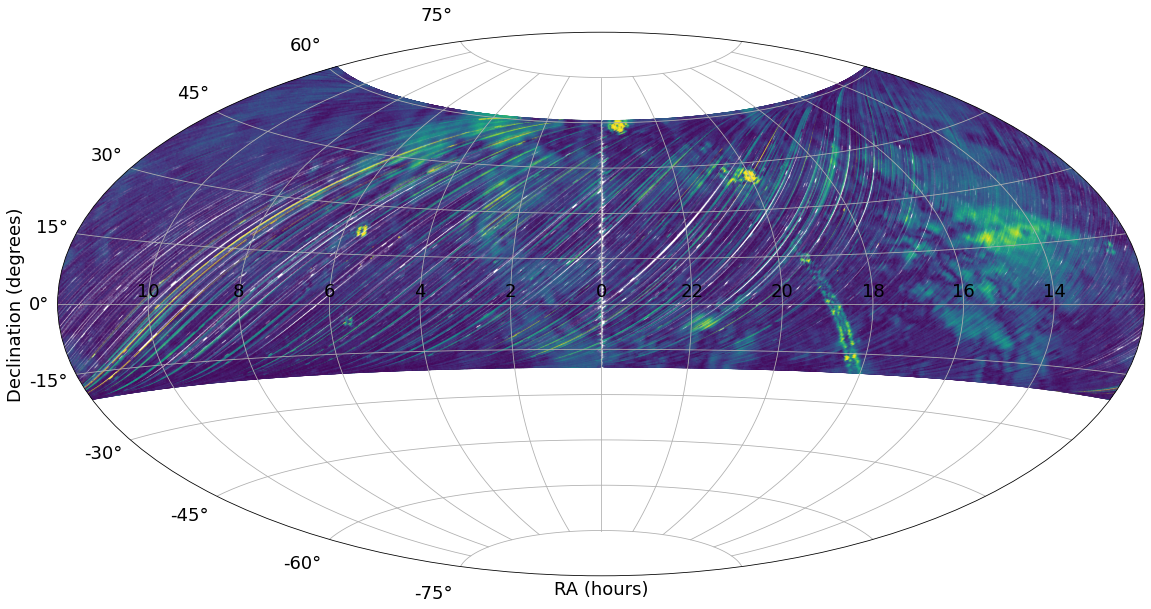

In [14]:
######################################################
### Select frequency index to plot:
frq_idx = 1

fs=18
Pmin = 0
Pmax = 2e5
#Pmin = 70.0
#Pmax = 72.5
spts = 1
######################################################

fig = plt.figure(figsize=(20,10))
plt.subplot(111, projection='aitoff')
plt.grid(True)

######################################################
#data_plot = 10*np.log10(LL_set3[wgood3,frq_idx])[0]
data_plot = PI3[:,frq_idx]
print(data_plot.shape)
wEast20 = np.where((az_set3 <= 180.) & (el_set3 < 25.) )[0]
wWest20 = np.where((az_set3 >= 180.) & (el_set3 < 25.) )[0]
wEast49 = np.where((az_set3 <= 180.) & (el_set3 > 40.) )[0]
wWest49 = np.where((az_set3 >= 180.) & (el_set3 > 40.) )[0]
idx = wWest20
eq = SkyCoord(ra3[idx], dec3[idx], frame='icrs', unit=u.deg)
######################################################
plt.scatter(-eq.ra.wrap_at('180d').radian, eq.dec.radian,s=spts,c=data_plot[idx]*0.83,
            vmin=Pmin,vmax=Pmax,alpha=0.3)

######################################################
#data_plot = 10*np.log10(LL_set1[wgood1,frq_idx])[0]
data_plot = PI1[:,frq_idx]
wEast20 = np.where((az_set1 <= 180.) & (el_set1 < 25.) )[0]
wWest20 = np.where((az_set1 >= 180.) & (el_set1 < 25.) )[0]
wEast49 = np.where((az_set1 <= 180.) & (el_set1 > 40.) )[0]
wWest49 = np.where((az_set1 >= 180.) & (el_set1 > 40.) )[0]
idx = wWest20
eq = SkyCoord(ra1[idx], dec1[idx], frame='icrs', unit=u.deg)
######################################################
plt.scatter(-eq.ra.wrap_at('180d').radian, eq.dec.radian,s=spts,c=data_plot[idx],
            vmin=Pmin,vmax=Pmax,alpha=0.3)


#plt.scatter(-eq.ra.wrap_at('180d').radian, eq.dec.radian,s=spts,c=data_plot,vmin=Pmin, vmax=Pmax,alpha=0.4)
positions = (-150*np.pi/180.,-120*np.pi/180.,-90*np.pi/180.,-60*np.pi/180.,-30*np.pi/180.,0,
             30*np.pi/180.,60*np.pi/180.,90*np.pi/180.,120*np.pi/180.,150*np.pi/180.)
labels = ("10","8","6","4","2","0","22","20","18","16","14")
plt.xticks(positions, labels,fontsize=fs)
plt.yticks(fontsize=fs)
plt.ylabel('Declination (degrees)',fontsize=fs)
plt.xlabel('RA (hours)',fontsize=fs)


## Map in Galactic coordinates

(2447873,)


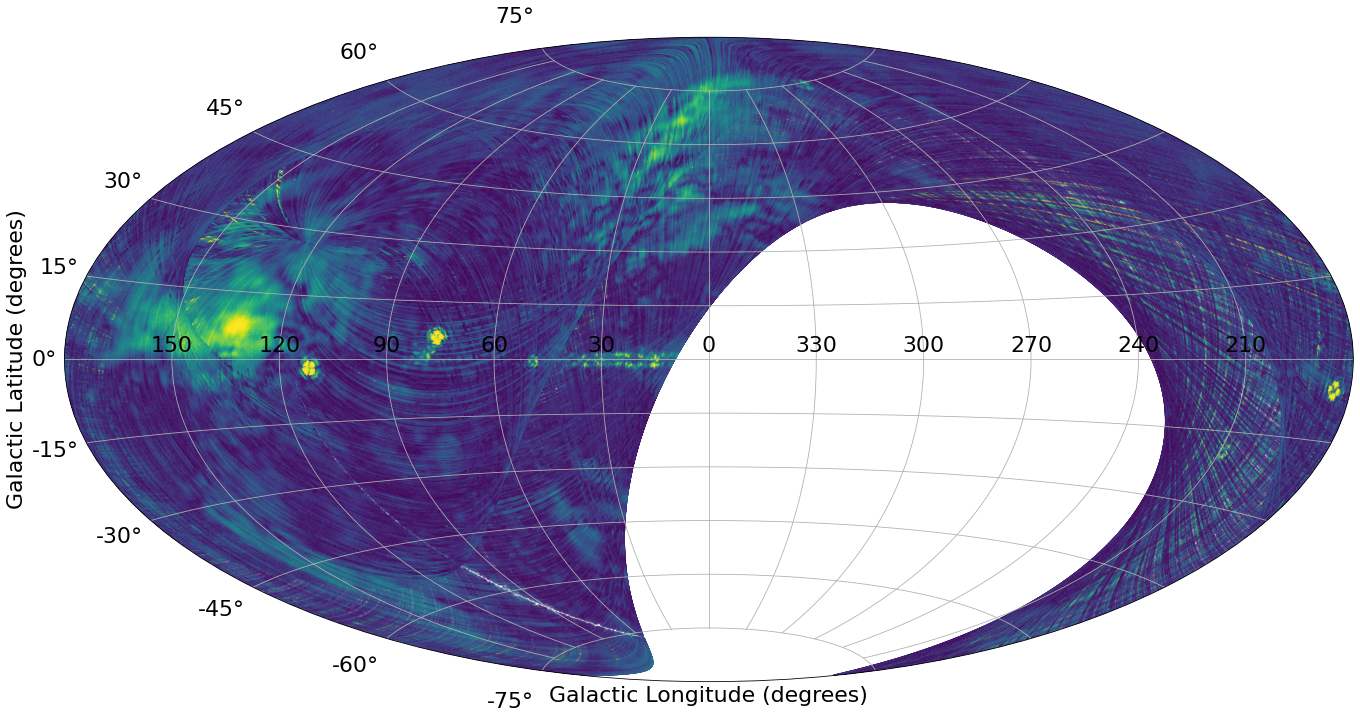

In [14]:
######################################################
### Select frequency index to plot:
frq_idx = 1

fs=22
Pmin = 0
Pmax = 2e5
#Pmin = 70.0
#Pmax = 72.0
spts = 1
#proj = 'rectilinear'
proj = 'aitoff'
######################################################

fig = plt.figure(figsize=(20,10))
plt.subplot(111, projection=proj)
plt.grid(True)

######################################################
#data_plot = 10*np.log10(LL_set3[:,frq_idx])
data_plot = PI3[:,frq_idx]
print(data_plot.shape)
wEast20 = np.where((az_set3 <= 180.) & (el_set3 < 25.) )[0]
wWest20 = np.where((az_set3 >= 180.) & (el_set3 < 25.) )[0]
wEast49 = np.where((az_set3 <= 180.) & (el_set3 > 40.) )[0]
wWest49 = np.where((az_set3 >= 180.) & (el_set3 > 40.) )[0]
idx = wEast49
#gal = SkyCoord(l3[idx], b3[idx], frame='galactic', unit=u.deg)
gal = SkyCoord(l3, b3, frame='galactic', unit=u.deg)
######################################################
if proj == 'rectilinear':
    plt.scatter(-gal.l.wrap_at('180d').deg, gal.b.deg,s=spts,c=data_plot*0.83,
                vmin=Pmin,vmax=Pmax,alpha=0.3)
if proj == 'aitoff':
    plt.scatter(-gal.l.wrap_at('180d').radian, gal.b.radian,s=spts,c=data_plot-0.8,
                vmin=Pmin,vmax=Pmax,alpha=0.3)

######################################################
#data_plot = 10*np.log10(LL_set1[:,frq_idx])
data_plot = PI1[:,frq_idx]
wEast20 = np.where((az_set1 <= 180.) & (el_set1 < 25.) )[0]
wWest20 = np.where((az_set1 >= 180.) & (el_set1 < 25.) )[0]
wEast49 = np.where((az_set1 <= 180.) & (el_set1 > 40.) )[0]
wWest49 = np.where((az_set1 >= 180.) & (el_set1 > 40.) )[0]
idx = wEast49
#gal = SkyCoord(l1[idx], b1[idx], frame='galactic', unit=u.deg)
gal = SkyCoord(l1, b1, frame='galactic', unit=u.deg)
######################################################
if proj == 'rectilinear':
    plt.scatter(-gal.l.wrap_at('180d').deg, gal.b.deg,s=spts,c=data_plot,
                vmin=Pmin,vmax=Pmax,alpha=0.3)
if proj == 'aitoff':
    plt.scatter(-gal.l.wrap_at('180d').radian, gal.b.radian,s=spts,c=data_plot,
                vmin=Pmin,vmax=Pmax,alpha=0.3)

if proj == 'rectilinear':
    positions = (0,45,90,135,180,225,270,315,360)
    labels = ("0","315","270","225","180","135","90","45","0")
if proj == 'aitoff':
    positions = (-150*np.pi/180.,-120*np.pi/180.,-90*np.pi/180.,-60*np.pi/180.,-30*np.pi/180.,0,
                 30*np.pi/180.,60*np.pi/180.,90*np.pi/180.,120*np.pi/180.,150*np.pi/180.)
    #positions = (-150,-120,-90,-60,-30,0,30,60,90,120,150)
    labels = ("150","120","90","60","30","0","330","300","270","240","210")

plt.xticks(positions, labels,fontsize=fs)
plt.yticks(fontsize=fs)
plt.xlabel('Galactic Longitude (degrees)',fontsize=fs)
plt.ylabel('Galactic Latitude (degrees)',fontsize=fs)
if proj == 'rectilinear':
    plt.gca().set_aspect('equal')

plt.tight_layout()
plt.savefig('/home/aordog/DVA_PLOTS/survey_phase1and3_800_gal_PI.jpg')